# IXO Modelling

**Terminology:**

Mechanisms:
* Pool: pool of specific token / collateral type
* Bridge: pre-IBC mirror between Ethereum and IXO-Cosmos, implementation is irrelevant for now
* Supply Pool/Market maker: issues IXO tokens in exchange for DAI
* Liquidity Pool/Brokerage: issues IXOS / staking tokens to delegators

Network:
* nodes represent mechanisms, pools, and participants
* edges represent relationships, such as token balances, amongst mechanisms, pools, and participants
* the total pool balance is the sum of all edges conected to that pool

Tokens:
* c_ - IXO-Cosmos equivalent of Ethereum tokens
* native - native to IXO-Cosmos network
* cIXOS - staking tokens 
* cIXO - utility tokens

![system-diagram](./ixo-liquidity-diagram_v2.png)

### Dependancies

In [1]:
from modules import *
%matplotlib inline

import logging

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(filename='experiment.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger('') 
logger.info('Logging configured')

### Liquidity Mechanisms and Actors Overview

In [2]:
from enum import Enum, auto
class Nodes(Enum):
    POOL = auto() # Pool of specific token / collateral
    FEE_POOL = auto() # Black-box for fee collection
    STAKE_POOL = auto() # Black-box for stake collection
    # Mechanisms
    MARKET_MAKER = auto() # Issues IXO tokens in exchange for DAI
    BROKERAGE = auto() # Issues staking tokens to delegators
    ARBITRAGE = auto()
    # Actors
    SERVICE_PROVIDER = auto() # makes claims about contributions and state of project
    EVALUATOR = auto() # validates claims
    DELEGATOR = auto() # stakes into the brokerage to provide liquidity
    PARTICIPANT = auto() # generic type for any user of IXO-Cosmos utility tokens
    # Generic actors
    GENERIC_DELEGATOR = auto()
    GENERIC_PARTICIPANT = auto()
    
class Edges(Enum):
    BALANCE = auto()
    BRIDGE = auto() # IBC style mirror

### Global Parameters

In [3]:
# Founders staked at 1:10 -- where DAI/IXO pair are entered into liquidity pool to receive staking vouchers, founders receive 1/10th of the value or share of the pool
# founders_stake = .1 # percent
# Note: this is irrelevant in model, because of assumption of delegators being staked during bootstrap phase
initial_ixos_supply = 100_000_000 # initial_ixo_supply * founders_stake # initial supply of staking vouchers
initial_ixos_price = .20 # staking voucher price from AMM in Euro cents

# Brokerage - Kyber Fed Price Reserve
# Policy to bound proposed conversion rate
sanity_rate = 10 # 1 DAI = 10 IXO
reasonable_difference = .1 # percent

# Target portfolio
# 50% DAI / 50% IXO

# Rebalancing
# Or: auto_instant - rebalance performed after every trade
time_spacing = 1 # time period after which to perform another rebalance
price_spacing_diff = .5 # percentage difference from last rebalance after which to perform another rebalance

# Pricing
maximum_spread = 0.02 # dictated by for example Kyber
minimum_spread = 0.005
spread = 0.01 # dependant on liquidity
quoted_price = 0 # TODO

# cadCAD configuration
days_in_month = 30 # approx.
time_steps = 12*days_in_month # days for more granularity - NB: all transaction rates in days

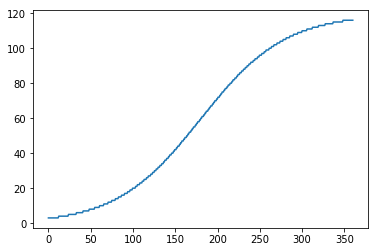

In [4]:
# Number of actors
max_participants = 120

# Sigmoidal growth
default_inflection = time_steps/2
default_slope = 1/50

def sigmoidal_growth(step, max_value, inflection=default_inflection, slope=default_slope):
    y = np.divide(max_value, (1 + np.power(np.e, -np.multiply(np.subtract(step, inflection), slope))))
    y = np.floor(y)
    y[y < 0] = 0
    return y

x = np.linspace(0, time_steps, 500)
y = sigmoidal_growth(x, max_participants)

plt.plot(x, y)
plt.show()

### cadCAD Parameters and Initial State

In [5]:
# cadCAD Parameter Sets
#####################################################################

# amm == automated market maker
# brk == brokerage

def sweep_range(params):
    max_len = 1
    for key in params:
        param_length = len(params[key])
        if param_length > max_len:
            max_len = param_length
    return list(range(1, max_len + 1)) or [1] 

params = {
    # Hatch phase
    'initial_ixo_supply': [1_660_495_658],
    'initial_ixo_price': [.03], # average IXO price from ixo.world Euro cents
    # Automated Market Maker parameters
    'amm.kappa': [1.2, 6],
    'amm.tax_rate': [0.02],
    'amm.theta': [0],
    # Arbitrage
    'arbitrage_roi': [False], # False == no arbitrage
    # Brokerage
    'brk.trade_fee': [0.02],
    'brk.sanity_rate': [10], # 1 DAI = 10 IXO
    'brk.reasonable_diff': [.5], # percent
    'brk.rebalance_diff': [False], # percentage difference from last rebalance after which to perform another rebalance
    'brk.max_spread': [.02], # price
    'brk.min_spread': [.005],
    # Transactions
    'max_participants': [max_participants],
    'participant_seed_collateral': [500],
    'supply_pool_tx_rate': [0],
    'supply_pool_tx_count': [5],
    'supply_pool_tx_value': [1e6],
    # Fees
    'daily_service_fee': [2], # daily fee (IXO) for users of system for gas and services, sent to fee pool black-box e.g. 2 IXO == 0.2 DAI cents, or 6 DAI/month 
}

params['sweep'] = sweep_range(params) # for selecting parameter sweep from results - unique ID

initial_state = {
    'valid_system_state': True,
    'amm.supply': 0,
    'amm.reserve': 0,
    'amm.spot_price': 0,
    'amm.invariant': 0,
    'lp.supply': 0,
    'lp.reserve': 0,
    'lp.spot_price': 0,
    'lp.voucher_price': 0,
}

params['sweep']

[1, 2]

### Brokerage / liquidity framework

In [6]:
# Brokerage framework / liquidity provision (see Uniswap/Kyber)
# https://github.com/runtimeverification/verified-smart-contracts/blob/uniswap/uniswap/x-y-k.pdf
# Newly added... found post setting this up: https://github.com/BlockScience/uniswap

# e.g. reserve == DAI
# e.g. supply == IXO
# e.g. voucher == IXOS

def add_liquidity(reserve_balance, supply_balance, voucher_balance, tokens, value):
    logger.info('voucher_balance %s' % voucher_balance)
    if voucher_balance <= 0:        
        dr = value
        ds = tokens
        dv = tokens
        return (dr, ds, dv)
    
    alpha = value/reserve_balance
    
    dr = alpha*reserve_balance
    ds = alpha*supply_balance
    dv = alpha*voucher_balance
    
    #new_reserve = (1 + alpha)*reserve_balance
    #new_supply = (1 + alpha)*supply_balance
    #new_vouchers = (1 + alpha)*voucher_balance
    
    return (dr, ds, dv)

def remove_liquidity(reserve_balance, supply_balance, voucher_balance, tokens):
    alpha = tokens/voucher_balance
    
    dr = -alpha*reserve_balance
    ds = -alpha*supply_balance
    dv = -alpha*voucher_balance
    
    #new_reserve = (1 - alpha)*reserve_balance
    #new_supply = (1 - alpha)*supply_balance
    #new_liquidity_tokens = (1 - alpha)*liquidity_token_balance
    
    return (dr, ds, dv)

# How much y received for selling dx?
def get_input_price(dx, x_balance, y_balance, trade_fee=0.01):
    rho = trade_fee
    
    alpha = dx/x_balance
    gamma = 1 - rho
    
    dy = (alpha*gamma / (1 + alpha*gamma))*y_balance
    
    _dx = alpha*x_balance
    _dy = -dy
    
    #new_x = (1 + alpha)*x_balance
    #new_y = y_balance - dy
    
    return (_dx, _dy)

# How much x needs to be sold to buy dy?
def get_output_price(dy, x_balance, y_balance, trade_fee=0.01):
    rho = trade_fee
    
    beta = dy/y_balance
    gamma = 1 - rho
    
    dx = (beta / (1 - beta))*(1 / gamma)*x_balance
    
    _dx = dx
    _dy = -beta*y_balance
    
    #new_x = x_balance + dx
    #new_y = (1 - beta)*y_balance
    
    return (_dx, _dy)

# Token trading
def collateral_to_token(value, reserve_balance, supply_balance, trade_fee):
    if reserve_balance == 0: return 0 #TODO: handle this case better
    dx,dy = get_input_price(value, reserve_balance, supply_balance, trade_fee)
    
    #new_reserve = reserve_balance + dx
    #new_supply = supply_balance - dy
    
    return abs(dy)

def token_to_collateral(tokens, reserve_balance, supply_balance, trade_fee):
    if supply_balance == 0: return 0 #TODO: handle this case better
    dx,dy = get_input_price(tokens, supply_balance, reserve_balance, trade_fee)
    
    #new_reserve = reserve_balance - dx
    #new_supply = supply_balance + dy
    
    return abs(dy)

### Initialize System

In [7]:
# Node generators
def add_new_pool(
        network,
        ticker):
    
    network.add_node(ticker, _type=Nodes.POOL.name)
    return network
        
def add_liquidity_mechanism(
        network,
        _params,
        pair=('DAI', 'IXO')):
    
    pair_id = generate_pair_id(Nodes.BROKERAGE, pair)
    network.add_node(pair_id, _type=Nodes.BROKERAGE.name)
    network.add_edge(pair_id, pair[0], _type=Edges.BALANCE.name, balance=0) # reserve: DAI
    network.add_edge(pair_id, pair[1], _type=Edges.BALANCE.name, balance=0) # supply: IXO
    
    brokerage = {}
    brokerage['target'] = .5 # Target portfolio pair[0]:pair[1]
    brokerage['rate'] = _params['brk.sanity_rate'] #TODO
    brokerage['sanity_rate'] = _params['brk.sanity_rate']
    brokerage['reasonable_diff'] = _params['brk.reasonable_diff']
    brokerage['rebalance_diff'] = _params['brk.rebalance_diff']
    brokerage['max_spread'] = _params['brk.max_spread']
    brokerage['min_spread'] = _params['brk.min_spread']
    brokerage['reserve_type'] = pair[0]
    brokerage['supply_type'] = pair[1]
    brokerage['voucher_type'] = pair[1] + 'S' # can be made more robust
    
    network.nodes[pair_id].update(brokerage)
    return network

def add_supply_mechanism(
        network,
        _params,
        initial_reserve,
        initial_supply,
        initial_spot_price,
        initial_invariant,
        pair=('DAI', 'IXO')): # Collateral -> distributed token
    
    pair_id = generate_pair_id(Nodes.MARKET_MAKER, pair)
    network.add_node(pair_id, _type=Nodes.MARKET_MAKER.name)
    
    network.add_edge(pair_id, pair[0], _type=Edges.BALANCE.name, balance=0)
    network.add_edge(pair_id, pair[1], _type=Edges.BALANCE.name, balance=0)
    
    market_maker = {}
    market_maker['pair'] = pair # Reserve/collateral -> supply/token
    market_maker['reserve_type'] = pair[0]
    market_maker['supply_type'] = pair[1]
    market_maker['kappa'] = _params['amm.kappa']
    market_maker['invariant'] = initial_invariant
    market_maker['tax_rate'] = _params['amm.tax_rate']
    market_maker['spot_price'] = initial_spot_price
    
    # Initialize pools
    reserve_edge = network.edges[(pair_id, market_maker['reserve_type'])]
    supply_edge = network.edges[(pair_id, market_maker['supply_type'])]
    reserve_edge['balance'] = initial_reserve
    supply_edge['balance'] = initial_supply
    
    network.nodes[pair_id].update(market_maker)
    return network

def add_new_bridge(
        network,
        _params=params,
        pair=('IXO', 'cIXO')):
    
    network.add_edge(pair[0], pair[1], _type=Edges.BRIDGE.name, balance=0)

def add_new_actor(
        network,
        _type,
        _params=params):
    
    _id = len([node for node in network.nodes])
    network.add_node(_id, _type=_type)
    
    actor = {}
    actor['key'] = 'value'
    
    network.node[_id].update(actor)
    
    return _id

def initialize_network():
    logger.info('Initializing network')
    network = nx.Graph()
    color_map = []
    
    pools = ['IXOS','cIXOS']
    
    for ticker in pools:
        color_map.append('orange')
        add_new_pool(network, ticker)
        
    bridges = [
        ('DAI', 'cDAI'),
        ('IXO', 'cIXO'),
        ('IXOS', 'cIXOS'),
    ]
    
    for pair in bridges:
        add_new_bridge(network, params, pair)
        
    generic_actor_types = [
        Nodes.GENERIC_DELEGATOR.name,
        Nodes.GENERIC_PARTICIPANT.name,
    ]
    
    for actor_type in generic_actor_types:
        _id = add_new_actor(network, actor_type)
    
    # Seed arbitrage mechanism with 10_000 DAI and 100_000 IXO
    _id = add_new_actor(network, Nodes.ARBITRAGE.name)
    network.add_edge(_id, 'DAI', _type=Edges.BALANCE.name, balance=10_000)
    network.add_edge(_id, 'IXO', _type=Edges.BALANCE.name, balance=100_000)
    # Add fee collection mechanism
    _id = add_new_actor(network, Nodes.FEE_POOL.name)
    network.add_edge(_id, 'IXO', _type=Edges.BALANCE.name, balance=0)
    # Add stake collection mechanism
    _id = add_new_actor(network, Nodes.STAKE_POOL.name)
    network.add_edge(_id, 'IXOS', _type=Edges.BALANCE.name, balance=0)
        
    return (network, color_map)

def network_genesis(network, _params, state):
    logger.info('Network genesis')
    initial_supply = _params['initial_ixo_supply']
    initial_reserve, initial_invariant, initial_spot_price = \
        initialize_bonding_curve(initial_supply, initial_price=_params['initial_ixo_price'], kappa=_params['amm.kappa'], theta=_params['amm.theta'])
    
    brokerage_pairs = [
        ('DAI','IXO'),
        ('cDAI','cIXO')
    ]
    
    for pair in brokerage_pairs:
        for ticker in pair:
            add_new_pool(network, ticker)
        color_map.append('pink')
        add_liquidity_mechanism(network, _params, pair)
        
    market_maker_pairs = [('DAI','IXO')]
    
    for pair in market_maker_pairs:
        for ticker in pair:
            add_new_pool(network, ticker)
        add_supply_mechanism(network, _params, initial_reserve, initial_supply, initial_spot_price, initial_invariant, pair)
        
    return network

## Helpers

In [8]:
def transfer(network, _from, _to, _value, _type, failsafe=False):
    assert(_value > 0)
    balance = network.edges[(_from, _type)]['balance']
    if not failsafe and not balance >= _value:
        logger.error('Insufficient balance')
        logger.info('Balance %s; Value %s' % (balance, _value))
        raise AssertionError('Insufficient balance')
    elif not network.edges[(_from, _type)]['balance'] >= _value:
        logger.error('Insufficient balance')
        logger.info('Balance %s; Value %s' % (balance, _value))
        return (False, balance)
    else:
        network.edges[(_from, _type)]['balance'] -= _value
        if not network.has_edge(_to, _type):
            network.add_edge(_to, _type, _type=Edges.BALANCE.name, balance=0)
        network.edges[(_to, _type)]['balance'] += _value
        return (True, _value)

def get_pool_balance(network, pool_node, filter_type=[None]):
    if not None in filter_type:
        edges = [(x,y) for x,y,z in network.edges(pool_node, data=True) 
                 if network.nodes[x].get('_type', None) in filter_type 
                 or network.nodes[y].get('_type', None) in filter_type]
    else:
        edges = network.edges(pool_node)
    balance = sum([network.edges[edge].get('balance', 0) for edge in edges])
    assert(balance >= 0)
    return balance

def balance_of(network, holder, pool, default=0):
    balance = network.edges[(holder, pool)].get('balance', default)
    assert(balance >= 0)
    return balance

def valid_system_state(s):
    return s['valid_system_state']

def invalidate_system_state():
    return ('valid_system_state', False)

## Policies

In [9]:
expon.rvs(size=10, loc=0.0, scale=100)

array([  1.25148558,   0.6472986 ,  11.05451903,  59.07856744,
       439.20264614, 119.83801952,  84.02745047,  46.60340512,
       124.26042479, 148.06102748])

In [10]:
def check_genesis(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    genesis = False
    if s['timestep'] == 0:
        logger.info('Genesis')
        genesis = True
        
    return ({'genesis': genesis})

def driving_process(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    network = s['network']
    
    participants = get_node_ids_of_type(network, Nodes.PARTICIPANT.name)
    participant_growth = sigmoidal_growth([s['timestep']], _params['max_participants'])[0]
    new_participants = math.ceil(participant_growth - len(participants))
    
    if new_participants:
        zipOf = zip(range(new_participants), expon.rvs(size=new_participants, loc=0.0, scale=_params['participant_seed_collateral']))
        new_participants_collateral = dict(zipOf)
    else:
        new_participants_collateral = {}
    
    return({'new_participants': new_participants,
            'new_participants_collateral': new_participants_collateral})

def participant_process(params, step, sL, s):
    if not valid_system_state(s): return ({})
    network = s['network']
    
    participants = get_node_ids_of_type(network, Nodes.PARTICIPANT.name)
    brokers = get_node_ids_of_type(network, Nodes.BROKERAGE.name)
    participants_with_collateral = filter(lambda p: network.edges[(p, 'DAI')].get('balance', 0)>0, participants)
    
    transactions = []
    for p in participants_with_collateral:
        transactions.append({
            'from': p,
            'type': 'DAI',
            'handler': ('DAI', 'IXO'),
            # Transfer all DAI holdings to brokerage, in exchange for IXO
            'value': network.edges[(p, 'DAI')]['balance'],
        })
    
    return({'transactions': transactions})

def supply_pool_process(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    network = s['network']
    
    generic_actor_type = Nodes.GENERIC_DELEGATOR.name
    actor = get_node_ids_of_type(network, generic_actor_type)[0]
    
    tx_rate = _params['supply_pool_tx_rate']
    tx_count = _params['supply_pool_tx_count']
    tx_value = _params['supply_pool_tx_value']
    
    perform_tx = False
    if tx_rate:
        perform_tx = s['timestep'] % (tx_rate*time_steps) < 1
    elif tx_count:
        perform_tx = s['timestep'] % (time_steps/tx_count) < 1
    else:
        raise
    
    transactions = []
    if perform_tx: # NB: this holds assuming less than 1 tx per day
        if not network.has_edge(actor, 'DAI'):
            network.add_edge(actor, 'DAI', _type=Edges.BALANCE.name, balance=0)
        network.edges[(actor, 'DAI')]['balance'] += 2*tx_value # mint DAI for IXO, and liquidity provision
        transactions.append({
            'from': actor,
            'type': 'DAI',
            'handler': ('DAI', 'IXO'),
            # Transfer all DAI collateral holdings to DAI:IXO market maker
            'value': tx_value,
        })
    
    return({'transactions': transactions})

def liquidity_pool_process(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    network = s['network']
    
    generic_actor_type = Nodes.GENERIC_DELEGATOR.name
    actor = get_node_ids_of_type(network, generic_actor_type)[0]
    
    tx_rate = _params['supply_pool_tx_rate']
    tx_count = _params['supply_pool_tx_count']
    
    perform_tx = False
    if tx_rate:
        perform_tx = s['timestep'] % (tx_rate*time_steps) < 1
    elif tx_count:
        perform_tx = s['timestep'] % (time_steps/tx_count) < 1
    else:
        raise
    
    transactions = []
    if perform_tx: # NB: this holds assuming less than 1 tx per day
        tx_value = balance_of(network, actor, 'IXO') #_params['supply_pool_tx_value']
        transactions.append({
            'from': actor,
            'type': generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO')),
            'handler': ('DAI', 'IXO'),
            # Transfer DAI equivalent of IXO holdings to liquidity pool 
            'value': tx_value,
        })
    
    return({'transactions': transactions})

def arbitrage_process(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    network = s['network']
    
    generic_actor_type = Nodes.ARBITRAGE.name
    actor = get_node_ids_of_type(network, generic_actor_type)[0]
    
    supply_handler_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
    supply_handler = network.nodes[supply_handler_id]
    liquidity_handler_id = generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO'))
    liquidity_handler = network.nodes[liquidity_handler_id]
    
    supply_pool_reserve = balance_of(network, supply_handler_id, 'DAI')
    supply_pool_supply = get_pool_balance(network, 'IXO')
    liquidity_pool_reserve = balance_of(network, liquidity_handler_id, 'DAI')
    liquidity_pool_supply = balance_of(network, liquidity_handler_id, 'IXO')
    
    V0 = invariant(
            supply_pool_reserve,
            supply_pool_supply,
            supply_handler['kappa'])
    
    # DAI -> Mint IXO -> perform swap for DAI via liquidity pool
    spot_price_supply_pool = spot_price(supply_pool_reserve, V0, supply_handler['kappa'])
    spot_price_liquidity_pool = token_to_collateral(1, liquidity_pool_reserve, liquidity_pool_supply, _params['brk.trade_fee'])

    arbitrage = False
    if spot_price_liquidity_pool > spot_price_supply_pool:
        tx_value = min(1000, balance_of(network, actor, 'DAI'))
        if liquidity_pool_supply > 0 and liquidity_pool_reserve > 0 and tx_value > 0:
            ds,realized_price = mint(tx_value, supply_pool_reserve, supply_pool_supply, V0, supply_handler['kappa'])
            dr = token_to_collateral(ds, liquidity_pool_reserve, liquidity_pool_supply, _params['brk.trade_fee'])
            # Check if ROI greater than 2%
            if _params['arbitrage_roi'] and dr - tx_value > _params['arbitrage_roi']*tx_value:
                arbitrage = {
                    'from': actor,
                    'to': generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO')),
                    'value': tx_value,
                    'realized_price': realized_price,
                    'ds': ds,
                    'dr': dr,
                }
    elif spot_price_liquidity_pool < spot_price_supply_pool:
        tx_value = min(10000, balance_of(network, actor, 'IXO'))
        if liquidity_pool_supply > 0 and liquidity_pool_reserve > 0 and tx_value > 0:
            ds = collateral_to_token(tx_value, liquidity_pool_reserve, liquidity_pool_supply, _params['brk.trade_fee'])
            dr,tax,realized_price = withdraw_with_tax(ds, supply_pool_reserve, supply_pool_supply, V0, supply_handler['tax_rate'], supply_handler['kappa'])
            # Check if ROI greater than 2%
            if _params['arbitrage_roi'] and dr - tx_value > _params['arbitrage_roi']*tx_value:
                arbitrage = {
                    'from': actor,
                    'to': generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO')),
                    'value': tx_value,
                    'realized_price': realized_price,
                    'ds': ds,
                    'dr': dr,
                }
            
    return({'arbitrage': arbitrage})

def collect_fee_process(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    network = s['network']
    
    value = _params['daily_service_fee']
    
    participants = get_node_ids_of_type(network, Nodes.PARTICIPANT.name)
    participants_with_ixo = list(filter(lambda p: network.has_edge(p, 'IXO') and network.edges[(p, 'IXO')].get('balance', 0)>value, participants))
    
    fees = {
        'value': value,
        'participants': participants_with_ixo,
    }
    
    return({'fees': fees})

def accounting(_params, step, sL, s):
    update = s['timestep'] > 1
    return({'update': update})

def sync(_params, step, sL, s):
    if not valid_system_state(s): return ({})
    return({'update': True})

## Mechanisms for updating the state based on driving processes

In [11]:
def perform_genesis(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    genesis = _input['genesis']
    if genesis:
        logging.info('Perform genesis')
        network = network_genesis(network, _params, s)
    
    key = 'network'
    value = network
        
    return (key, value)

def sync_bridges(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    bridges = get_edge_ids_of_type(network, Edges.BRIDGE.name)
    for edge_id in bridges:
        bridge = network.edges[edge_id]
        bridge['balance'] = get_pool_balance(network, edge_id[0])
        
    key = 'network'
    value = network
        
    return (key, value)

def collect_fees(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    generic_actor_type = Nodes.FEE_POOL.name
    fee_pool = get_node_ids_of_type(network, generic_actor_type)[0]
    
    fees = _input['fees']
    value = fees['value']
    participants = fees['participants']
    
    for participant in participants:
        transfer(network, participant, fee_pool, value, 'IXO')
        
    key = 'network'
    value = network
    
    return (key, value)

def perform_arbitrage(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    #'from': actor,
    #'value': tx_value,
    #'realized_price': realized_price,
    #'ds': ds,
    #'dr': dr,
    arbitrage = _input['arbitrage']
    supply_handler_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
    liquidity_handler_id = generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO'))
    
    if arbitrage:
        actor = arbitrage['from']
        to = arbitrage['to']
        tx_value = arbitrage['value']
        realized_price = arbitrage['realized_price']
        ds = arbitrage['ds']
        dr = arbitrage['dr']
        
        supply_reserve_balance = balance_of(network, supply_handler_id, 'DAI')
        liquidity_reserve_balance = balance_of(network, liquidity_handler_id, 'DAI')
        
        if to == supply_handler_id:
            logger.info('Perform arbitrage %s->%s: %s' % (supply_handler_id, liquidity_handler_id, arbitrage))
            if not network.has_edge(actor, 'IXO'):
                network.add_edge(actor, 'IXO', _type=Edges.BALANCE.name, balance=0)

            # Mint IXO
            transfer(network, actor, supply_handler_id, tx_value, 'DAI')
            network.edges[(actor, 'IXO')]['balance'] += ds

            # Swap for DAI
            if ds and balance_of(network, actor, 'IXO') >= ds and liquidity_reserve_balance >= dr:
                roi = dr/tx_value
                logger.info('ROI %s' % roi)
                transfer(network, actor, liquidity_handler_id, ds, 'IXO')
                transfer(network, liquidity_handler_id, actor, dr, 'DAI')
        elif to == liquidity_handler_id:
            logger.info('Perform arbitrage %s->%s: %s' % (liquidity_handler_id, supply_handler_id, arbitrage))
            # Swap for IXO
            transfer(network, actor, liquidity_handler_id, tx_value, 'DAI')
            transfer(network, liquidity_handler_id, actor, ds, 'IXO')
            
            # Withdraw for Dai
            if dr and balance_of(network, supply_handler_id, 'IXO') >= ds and supply_reserve_balance >= dr:
                roi = dr/tx_value
                logger.info('ROI %s' % roi)
                network.edges[(supply_handler_id, 'IXO')]['balance'] -= ds
                transfer(network, supply_handler_id, actor, dr, 'DAI')
    
    key = 'network'
    value = network
    
    return (key, value)

def update_network(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    new_participants = _input['new_participants'] # Number of
    new_participants_collateral = _input['new_participants_collateral'] # Dict
    
    for i in range(new_participants):
        _id = add_new_actor(network, Nodes.PARTICIPANT.name)
        # Deposit seed collateral
        network.add_edge(_id, 'DAI', balance=new_participants_collateral[i])
            
    key = 'network'
    value = network
    
    return (key, value)

def update_balances(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    # Process transactions and update balances
    # [{'from': 10, 'type': 'DAI', 'handler': ('DAI', 'IXO'), 'value': 0}]
    transactions = _input['transactions']
    
    logger.info(transactions)
    for tx in transactions:
        handler_id = generate_pair_id(Nodes.MARKET_MAKER, tx['handler'])
        handler = network.nodes[handler_id]
        assert(handler['_type'] == Nodes.MARKET_MAKER.name)
        
        # Collateral -> token; e.g. DAI -> IXO
        participant = tx['from']
        reserve_pool = handler['reserve_type']
        supply_pool = handler['supply_type']
        reserve = balance_of(network, handler_id, handler['reserve_type'])
        supply = get_pool_balance(network, handler['supply_type'])

        if tx['type'] == reserve_pool: # Mint
            logger.info('Mint %s' % tx['value'])
            V0 = invariant(
                reserve,
                supply,
                handler['kappa'])
            deltaS, realized_price = mint(
                tx['value'],
                reserve,
                supply,
                V0,
                handler['kappa'])

            # Update holdings
            transfer(network, participant, handler_id, tx['value'], reserve_pool)
            if not network.has_edge(participant, supply_pool):
                network.add_edge(participant, supply_pool, _type=Edges.BALANCE.name, balance=0)
            network.edges[(participant, supply_pool)]['balance'] += deltaS
            
            # Update market maker
            handler['invariant'] = V0
            handler['spot_price'] = spot_price(
                reserve,
                handler['invariant'],
                handler['kappa'])

        elif tx['type'] == supply_pool: # Withdraw
            logger.info('Withdraw %s' % tx['value'])
            V0 = invariant(
                reserve,
                supply,
                handler['kappa'])
            deltaR, realized_price = withdraw(
                tx['value'],
                reserve,
                supply,
                V0,
                handler['kappa'])

            # Update holdings
            transfer(network, handler_id, participant, deltaR, reserve_pool)
            network.edges[(participant, supply_pool)]['balance'] -= tx['value']

            # Update market maker
            handler['invariant'] = V0
            handler['spot_price'] = spot_price(
                reserve,
                handler['invariant'],
                handler['kappa'])

        else: raise # We shouldn't get here
    
    key = 'network'
    value = network
    
    return (key, value)

def update_brokerage(_params, step, sL, s, _input):
    if not valid_system_state(s): return ('','')
    network = s['network']
    
    # Process transactions and update balances
    # [{'from': 10, 'type': 'DAI', 'handler': ('DAI', 'IXO'), 'value': 0}]
    transactions = _input['transactions']

    logger.info(transactions)
    for tx in transactions:
        handler_id = generate_pair_id(Nodes.BROKERAGE, tx['handler'])
        handler = network.nodes[handler_id]
        market_maker_id = generate_pair_id(Nodes.MARKET_MAKER, tx['handler'])
        market_maker = network.nodes[market_maker_id]
        assert(handler['_type'] == Nodes.BROKERAGE.name)
        
        # Collateral -> token; e.g. DAI -> IXO
        participant = tx['from']
        reserve_pool = handler['reserve_type']
        supply_pool = handler['supply_type']
        voucher_pool = handler['voucher_type']
        
        reserve_balance =  balance_of(network, handler_id, reserve_pool)
        supply_balance = balance_of(network, handler_id, supply_pool)
        voucher_balance = get_pool_balance(network, voucher_pool)
        
        market_reserve = network.edges[(market_maker_id, reserve_pool)]['balance']
        market_supply = get_pool_balance(network, handler['supply_type'])
        
        if tx['type'] == handler_id and tx['value'] >= 10: # Provide liquidity, get IXOS
            logger.info('Provide liquidity %s' % tx['value'])
            logger.info((reserve_balance, supply_balance, voucher_balance))
            
            # Calculate a reasonable value for the supplied tokens
            #V0 = invariant(
            #    market_reserve,
            #    market_supply,
            #    market_maker['kappa'])
            #deltaR, realized_price = withdraw(
            #    tx['value'], # IXO token value
            #    market_reserve, 
            #    market_supply, 
            #    V0,
            #    market_maker['kappa'])
            deltaR = tx['value']*0.1 # hard-code liquidity provision valuation

            dr, ds, dv = add_liquidity(
                reserve_balance,
                supply_balance, 
                voucher_balance, 
                tx['value'], # IXO token value
                deltaR)
            logger.info((dr, ds, dv))
            
            # Account for change in bonding curve token value
            participant_balance = balance_of(network, participant, 'DAI')
            short = dr - participant_balance
            # If short, allocate difference
            if short > 0: 
                logger.info("Short %s DAI" % short)
                network.edges[(participant, 'DAI')]['balance'] += short
            
            transfer(network, participant, handler_id, dr, reserve_pool)
            passed,value = transfer(network, participant, handler_id, ds, supply_pool, failsafe=True)
            if not passed:
                diff = ds - value
                if not diff < 0.1:
                    logger.info("Error: diff %s" % diff)
                    return invalidate_system_state()
                transfer(network, participant, handler_id, value, supply_pool)

            if not network.has_edge(participant, voucher_pool):
                network.add_edge(participant, voucher_pool, _type=Edges.BALANCE.name, balance=0)
            network.edges[(participant, voucher_pool)]['balance'] += dv

        if tx['type'] == reserve_pool: # Swap reserve (DAI) for tokens (IXO)
            tokens = collateral_to_token(tx['value'], reserve_balance, supply_balance, _params['brk.trade_fee'])
            if tokens and balance_of(network, handler_id, supply_pool) >= tokens and balance_of(network, participant, reserve_pool) >= tx['value']:
                transfer(network, participant, handler_id, tx['value'], reserve_pool)
                transfer(network, handler_id, participant, tokens, supply_pool)
            
        if tx['type'] == supply_pool: # Swap tokens for reserve
            logger.warning('TODO')
        
    key = 'network'
    value = network
    
    return (key, value)

def update_reserve(_params, step, sL, s, _input):
    if not _input['update']: return ('','')
    network = s['network']
    
    handler_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
    handler = network.nodes[handler_id]
    
    reserve_pool = handler['reserve_type']
    market_reserve = balance_of(network, handler_id, reserve_pool)
    
    key = 'amm.reserve'
    value = market_reserve
    
    return (key, value)

def update_supply(_params, step, sL, s, _input):
    if not _input['update']: return ('','')
    network = s['network']
    
    handler_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
    handler = network.nodes[handler_id]
    
    supply_pool = handler['supply_type']
    market_supply = get_pool_balance(network, supply_pool)
    
    key = 'amm.supply'
    value = market_supply
    
    return (key, value)
    
def update_spot_price(_params, step, sL, s, _input):
    if not _input['update']: return ('','')
    network = s['network']
    
    handler_id = generate_pair_id(Nodes.MARKET_MAKER, ('DAI', 'IXO'))
    handler = network.nodes[handler_id]
    
    reserve = balance_of(network, handler_id, handler['reserve_type'])
    supply = get_pool_balance(network, handler['supply_type'])
    
    V0 = invariant(reserve, supply, handler['kappa'])
    price = spot_price(reserve, V0, handler['kappa'])
    
    key = 'amm.spot_price'
    value = price
    
    return (key, value)

def update_lp_spot_price(_params, step, sL, s, _input):
    if not _input['update']: return ('','')
    network = s['network']
    
    handler_id = generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO'))
    handler = network.nodes[handler_id]
    
    reserve_pool = handler['reserve_type']
    supply_pool = handler['supply_type']
    reserve_balance = balance_of(network, handler_id, reserve_pool)
    supply_balance = balance_of(network, handler_id, supply_pool)
    
    price = token_to_collateral(1, reserve_balance, supply_balance, _params['brk.trade_fee'])
    
    key = 'lp.spot_price'
    value = price
    
    return (key, value)

def update_lp_voucher_price(_params, step, sL, s, _input):
    if not _input['update']: return ('','')
    network = s['network']
    
    handler_id = generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO'))
    handler = network.nodes[handler_id]
    
    reserve_pool = handler['reserve_type']
    supply_pool = handler['supply_type']
    reserve_balance = balance_of(network, handler_id, reserve_pool)
    supply_balance = balance_of(network, handler_id, supply_pool)
    voucher_balance = get_pool_balance(network, 'IXOS')
    
    key = 'lp.voucher_price'
    if voucher_balance <= 0:
        return (key, 0)
    dr,ds,dv = remove_liquidity(reserve_balance, supply_balance, voucher_balance, 1)
    
    # Price assuming that IXOS token liquidated, and IXO returned converted to DAI via liquidity pool
    price = abs(dr) + token_to_collateral(abs(ds), reserve_balance, supply_balance, _params['brk.trade_fee'])
    
    value = price
    
    return (key, value)

### Initialize Network

/nix/store/325f3syzpdzd7byvj3ak07lc5jpky8bc-python3-3.7.2-env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


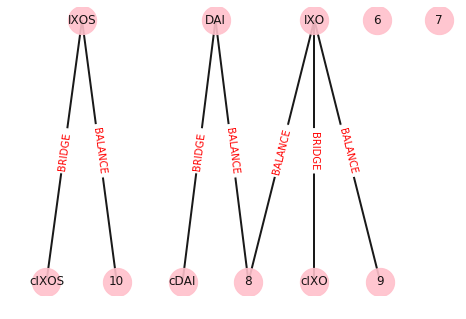

In [12]:
network, color_map = initialize_network()
pos = nx.drawing.nx_agraph.graphviz_layout(network, prog='dot') #spring_layout(network, k=0.15,iterations=20)

plt.figure()
nx.draw(
    network, pos, edge_color='black', width=2, linewidths=1,
    node_size=800, node_color='pink', alpha=0.9,
    labels={node: node for node in network.nodes()})

nx.draw_networkx_edge_labels(
    network, pos,
    edge_labels={(u,v): d['_type'] for u,v,d in network.edges(data=True)},
    font_color='red')

plt.axis('off')
plt.show()

#nx.draw_kamada_kawai(network, node_color=color_map, font_weight='bold', with_labels=True)

initial_state.update({
    'network': network,
})

### Configure cadCAD

In [13]:
runs = 1 # Monte Carlo runs

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps

simulation_parameters = config_sim({
    'T': range(time_steps),
    'N': runs,
    'M': params
})
simulation_parameters

[{'N': 1,
  'T': range(0, 360),
  'M': {'initial_ixo_supply': 1660495658,
   'initial_ixo_price': 0.03,
   'amm.kappa': 1.2,
   'amm.tax_rate': 0.02,
   'amm.theta': 0,
   'arbitrage_roi': False,
   'brk.trade_fee': 0.02,
   'brk.sanity_rate': 10,
   'brk.reasonable_diff': 0.5,
   'brk.rebalance_diff': False,
   'brk.max_spread': 0.02,
   'brk.min_spread': 0.005,
   'max_participants': 120,
   'participant_seed_collateral': 500,
   'supply_pool_tx_rate': 0,
   'supply_pool_tx_count': 5,
   'supply_pool_tx_value': 1000000.0,
   'daily_service_fee': 2,
   'sweep': 1}},
 {'N': 1,
  'T': range(0, 360),
  'M': {'initial_ixo_supply': 1660495658,
   'initial_ixo_price': 0.03,
   'amm.kappa': 6,
   'amm.tax_rate': 0.02,
   'amm.theta': 0,
   'arbitrage_roi': False,
   'brk.trade_fee': 0.02,
   'brk.sanity_rate': 10,
   'brk.reasonable_diff': 0.5,
   'brk.rebalance_diff': False,
   'brk.max_spread': 0.02,
   'brk.min_spread': 0.005,
   'max_participants': 120,
   'participant_seed_collateral': 

### Perform Simulation

In [14]:
# ts_format = '%Y-%m-%d %H:%M:%S'
# t_delta = timedelta(days=30, minutes=0, seconds=0)
# def time_model(_g, step, sL, s, _input):
#     y = 'time'
#     x = ep_time_step(s, dt_str=s['time'], fromat_str=ts_format, _timedelta=t_delta)
#     return (y, x)

# exogenous_states = {
# #     'time': time_model
# }
# env_processes = {}

partial_state_update_blocks = [
    { # Genesis
        'policies': {
            'genesis': check_genesis,
        },
        'variables': {
            'network': perform_genesis,
        }
    },
    { # Generate new participants
        'policies': {
            'generate': driving_process,
        },
        'variables': {
            'network': update_network,
        }
    },
    { # Actors enter supply pool
        'policies': {
            'supply': supply_pool_process,
        },
        'variables': {
            'network': update_balances,
        }
    },
    { # Actors provide liquidity via brokerage
        'policies': {
            'liquidity': liquidity_pool_process,
        },
        'variables': {
            'network': update_brokerage,
        }
    },
    {
        'policies': {
            'activity': participant_process,
        },
        'variables': {
            'network': update_brokerage,
        }
    },
    {
        'policies': {
            'arbitrage': arbitrage_process,
        },
        'variables': {
            'network': perform_arbitrage,
        }
    },
    {
        'policies': {
            'fees': collect_fee_process,
        },
        'variables': {
            'network': collect_fees,
        }
    },
#     { # Brokerage rebalance
#         'policies': {
#             'rebalance': brokerage_rebalance,
#         },
#         'variables': {
#             'network': update_brokerage,
#         }
#     },
    { # Accounting
        'policies': {
            'accounting': accounting,
        },
        'variables': {
            'amm.supply': update_supply,
            'amm.reserve': update_reserve,
            'amm.spot_price': update_spot_price,
            'lp.spot_price': update_lp_spot_price,
            'lp.voucher_price': update_lp_voucher_price,
        }
    },
#     { # Sync networks
#         'policies': {
#             'sync': sync,
#         },
#         'variables': {
#             'network': sync_bridges,
#         }
#     }
]

In [15]:
append_configs(
    initial_state=initial_state, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters, #dict containing simulation parameters
#     raw_exogenous_states=exogenous_states,
#     env_processes=env_processes
)

sys.setrecursionlimit(10000)
from cadCAD import configs

exec_mode = ExecutionMode()
exec_context = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=exec_context, configs=configs)

i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1

[{'N': 1, 'T': range(0, 360), 'M': {'initial_ixo_supply': 1660495658, 'initial_ixo_price': 0.03, 'amm.kappa': 1.2, 'amm.tax_rate': 0.02, 'amm.theta': 0, 'arbitrage_roi': False, 'brk.trade_fee': 0.02, 'brk.sanity_rate': 10, 'brk.reasonable_diff': 0.5, 'brk.rebalance_diff': False, 'brk.max_spread': 0.02, 'brk.min_spread': 0.005, 'max_participants': 120, 'participant_seed_collateral': 500, 'supply_pool_tx_rate': 0, 'supply_pool_tx_count': 5, 'supply_pool_tx_value': 1000000.0, 'daily_service_fee': 2, 'sweep': 1}}, {'N': 1, 'T': range(0, 360), 'M': {'initial_ixo_supply': 1660495658, 'initial_ixo_price': 0.03, 'amm.kappa': 6, 'amm.tax_rate': 0.02, 'amm.theta': 0, 'arbitrage_roi': False, 'brk.trade_fee': 0.02, 'brk.sanity_rate': 10, 'brk.reasonable_diff': 0.5, 'brk.rebalance_diff': False, 'brk.max_spread': 0.02, 'brk.min_spread': 0.005, 'max_participants': 120, 'participant_seed_collateral': 500, 'supply_pool_tx_rate': 0, 'supply_pool_tx_count': 5, 'supply_pool_tx_value': 1000000.0, 'daily_se

# Model Data Analysis

In [16]:
# Choose which experiment parameter configuration to use, integer starting from zero
import os

def select_experiment(results, i):
    df = pd.DataFrame(results[i - 1]['result'])
    directory = './experiment_%s/' % i
    if not os.path.exists(directory):
        os.makedirs(directory)
    return df[df.substep==len(partial_state_update_blocks)].copy()

def save_experiment(fig, experiment, name):
    pickle.dump(fig, open('experiment_%s/%s.pickle' % (experiment, name), 'wb'))
    fig.savefig('experiment_%s/%s.png' % (experiment, name))

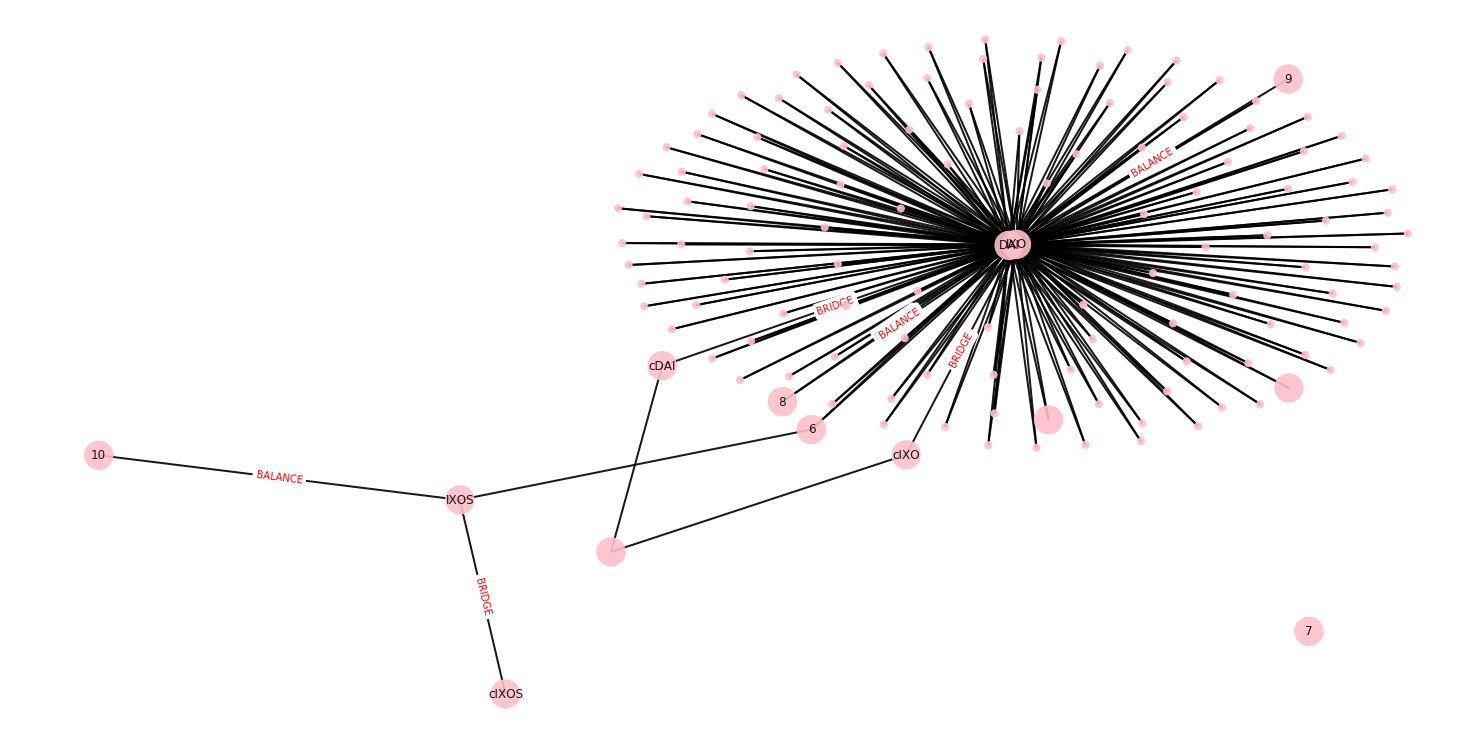

In [17]:
rdf = select_experiment(results, 1)
network_output = rdf['network'][rdf.index[-1]]

pos = nx.drawing.nx_agraph.graphviz_layout(network_output, prog='neato') #spring_layout(network, k=0.15,iterations=20)

node_sizes = [50 if network_output.nodes[node]['_type'] == Nodes.PARTICIPANT.name else 800 for node in network_output.nodes()]

plt.figure(1,figsize=(20,10))
nx.draw(
    network_output, pos, edge_color='black', width=2, linewidths=1,
    node_size=node_sizes, node_color='pink', alpha=0.9,
    labels={node: node for node in network.nodes()})

nx.draw_networkx_edge_labels(
    network_output, pos,
    edge_labels={(u,v): d['_type'] for u,v,d in network.edges(data=True)},
    font_color='red')

plt.axis('off')
plt.show()

Minimum spot price 0.03599783210320786
Maximum spot price 0.036576283783307
Minimum spot price 0.17998916051603964
Maximum spot price 0.1949227399843681
Minimum spot price 0.09830276243460923
Maximum spot price 0.10046660812399345
Minimum spot price 0.09952858902483178
Maximum spot price 0.11083551834057452


/nix/store/325f3syzpdzd7byvj3ak07lc5jpky8bc-python3-3.7.2-env/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


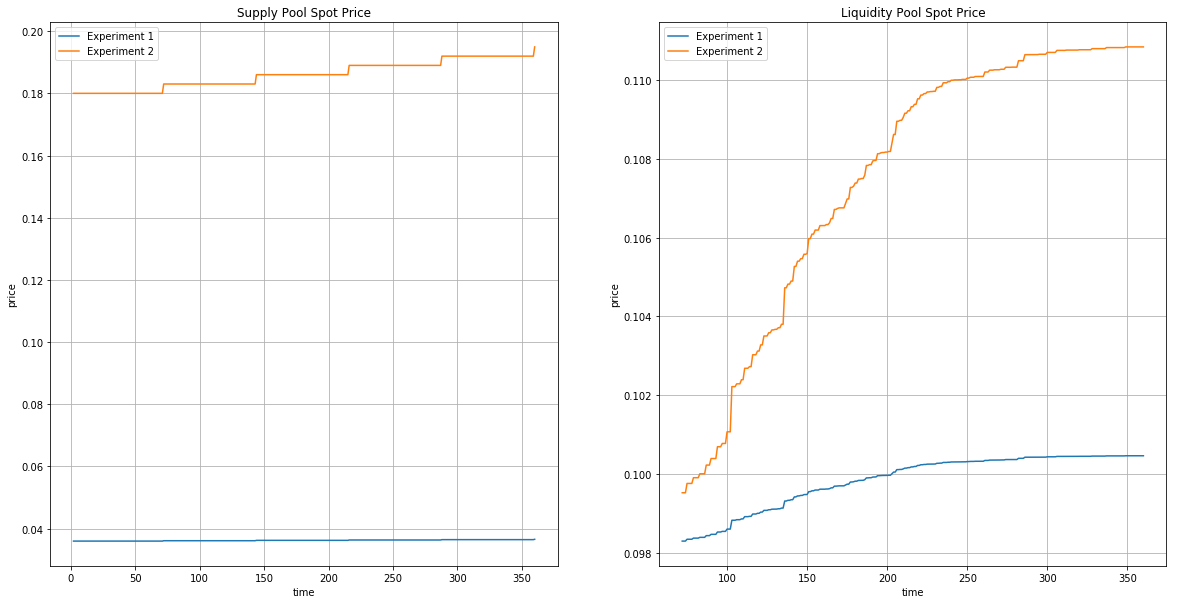

In [18]:
fig = plt.figure(figsize=(20,10))

for experiment in params['sweep']:
    data_id = 'amm.spot_price'
    rdf = select_experiment(results, experiment)
    rdf = rdf[rdf[data_id] > 0]

    plt.subplot(121)
    plt.plot(rdf.timestep, rdf[data_id], label="Experiment %s" % experiment)
    plt.title('Supply Pool Spot Price')
    plt.xlabel('time')
    plt.ylabel('price')
    plt.legend(loc='upper left')
    plt.grid(True)

    print('Minimum spot price %s' % min(rdf[data_id]))
    print('Maximum spot price %s' % max(rdf[data_id]))
    
for experiment in params['sweep']:
    data_id = 'lp.spot_price'
    rdf = select_experiment(results, experiment)
    rdf = rdf[rdf[data_id] > 0]

    plt.subplot(122)
    plt.plot(rdf.timestep, rdf[data_id], label="Experiment %s" % experiment)
    plt.title('Liquidity Pool Spot Price')
    plt.xlabel('time')
    plt.ylabel('price')
    plt.grid(True)
    plt.legend(loc='upper left')

    print('Minimum spot price %s' % min(i for i in rdf[data_id] if i > 0))
    print('Maximum spot price %s' % max(rdf[data_id]))
    
save_experiment(fig, 0, 'IXO_spot_price')

Minimum IXO 1660595658.0
Maximum IXO 1798374161.7299094
Minimum IXO 1660595658.0
Maximum IXO 1687279885.6940749
Minimum IXOS 0.0
Maximum IXOS 138257629.06695974
Minimum IXOS 0.0
Maximum IXOS 27118936.1073853
Minimum 49825998.863198675
Maximum 68825302.2926348
Minimum 49825998.863198675
Maximum 59879012.88395337


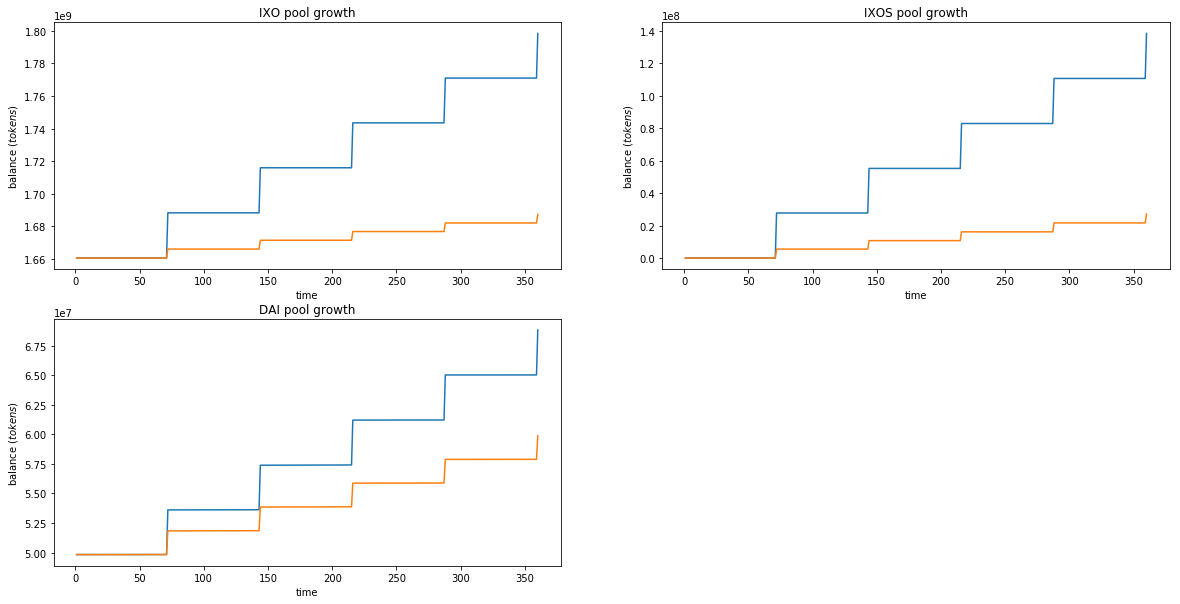

In [19]:
fig = plt.figure(figsize=(20,10))

for experiment in params['sweep']:
    rdf = select_experiment(results, experiment)
    rdf['IXO_pool_growth'] = rdf['network'].apply(lambda g: get_pool_balance(g, 'IXO'))

    plt.subplot(221)
    plt.plot(rdf.timestep, rdf['IXO_pool_growth'])
    plt.title('IXO pool growth')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    print('Minimum IXO %s' % min(rdf['IXO_pool_growth']))
    print('Maximum IXO %s' % max(rdf['IXO_pool_growth']))
    
for experiment in params['sweep']:
    data_id = 'IXOS_pool_growth'
    rdf = select_experiment(results, experiment)
    rdf[data_id] = rdf['network'].apply(lambda g: get_pool_balance(g, 'IXOS'))

    plt.subplot(222)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('IXOS pool growth')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    print('Minimum IXOS %s' % min(rdf[data_id]))
    print('Maximum IXOS %s' % max(rdf[data_id]))
    
for experiment in params['sweep']:
    rdf = select_experiment(results, experiment)
    rdf['DAI_pool_growth'] = rdf['network'].apply(lambda g: get_pool_balance(g, 'DAI'))

    plt.subplot(223)
    plt.plot(rdf.timestep, rdf['DAI_pool_growth'])
    plt.title('DAI pool growth')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    print('Minimum %s' % min(rdf['DAI_pool_growth']))
    print('Maximum %s' % max(rdf['DAI_pool_growth']))
    
save_experiment(fig, 0, 'IXO_IXOS_pool_growth')

Minimum reserve 49814869.739999995
Maximum reserve 54814869.739999995
Minimum reserve 49814869.739999995
Maximum reserve 54814869.739999995
Minimum supply 1660595658.0
Maximum supply 1798374161.7299094
Minimum supply 1660595658.0
Maximum supply 1687279885.6940749


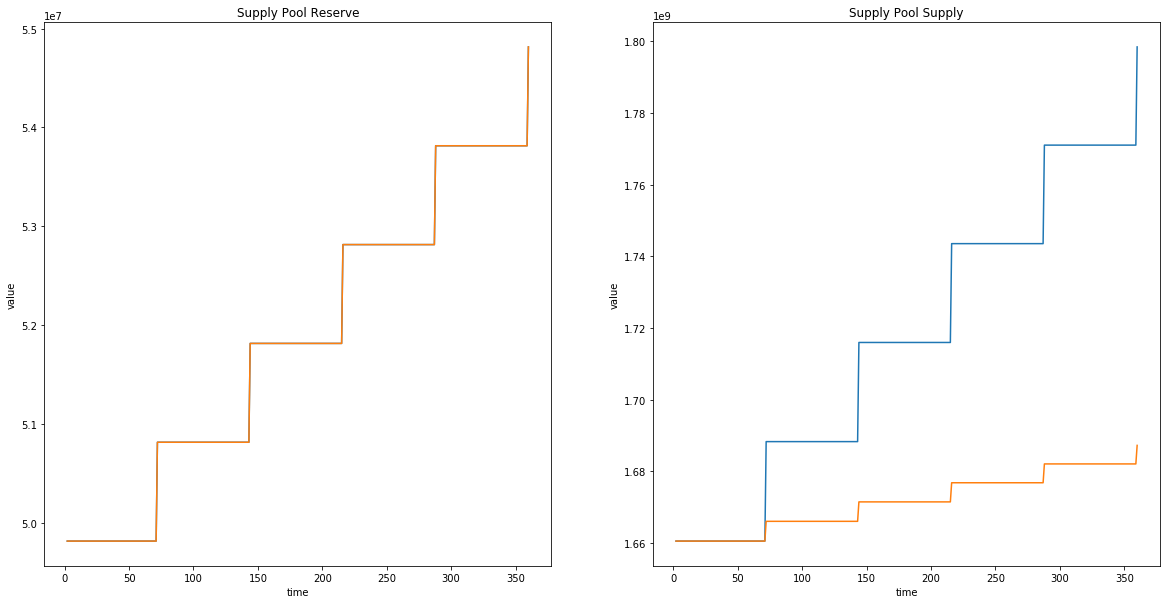

In [20]:
fig = plt.figure(figsize=(20,10))

for experiment in params['sweep']:
    data_id = 'amm.reserve'
    rdf = select_experiment(results, experiment)
    rdf = rdf[rdf[data_id] > 0]

    plt.subplot(121)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Supply Pool Reserve')
    plt.xlabel('time')
    plt.ylabel('value')

    print('Minimum reserve %s' % min(rdf[data_id]))
    print('Maximum reserve %s' % max(rdf[data_id]))
    
for experiment in params['sweep']:
    data_id = 'amm.supply'
    rdf = select_experiment(results, experiment)
    rdf = rdf[rdf[data_id] > 0]

    plt.subplot(122)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Supply Pool Supply')
    plt.xlabel('time')
    plt.ylabel('value')

    print('Minimum supply %s' % min(rdf[data_id]))
    print('Maximum supply %s' % max(rdf[data_id]))
    
save_experiment(fig, 0, 'supply_mechanism_reserve_supply')

Minimum reserve 2777657.83887411
Maximum reserve 14000432.5526348
Minimum reserve 555322.109582195
Maximum reserve 2885817.3981771185
Minimum supply 27536083.84569476
Maximum supply 136567005.28987116
Minimum supply 5318277.828892453
Maximum supply 25516197.189646386


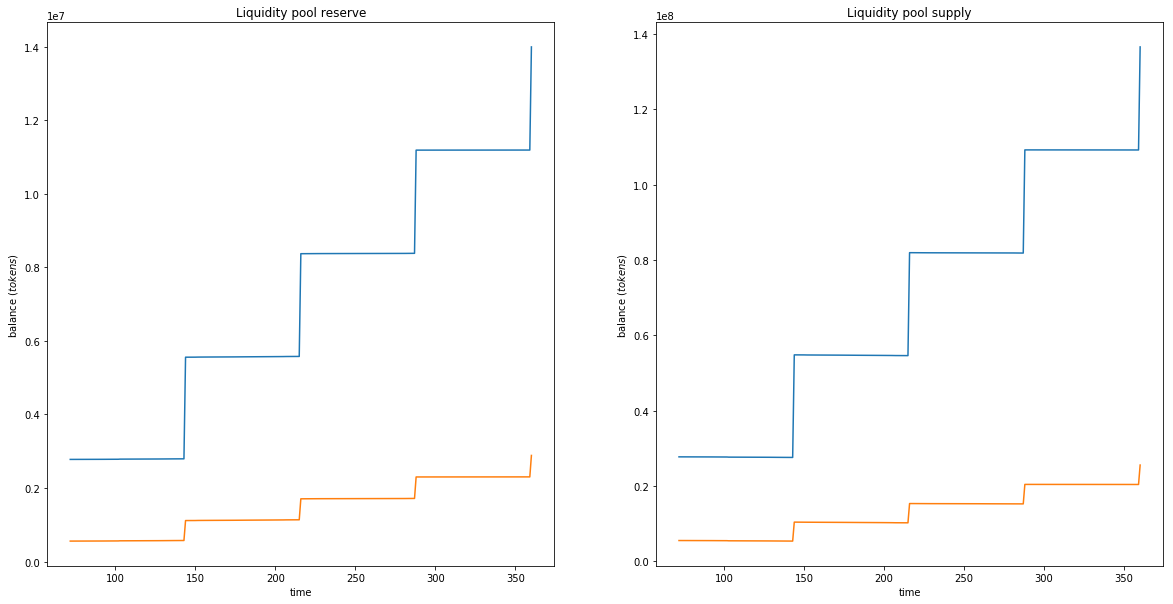

In [21]:
fig = plt.figure(figsize=(20,10))

handler_id = generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO'))

for experiment in params['sweep']:
    data_id = 'brokerage_pool_reserve'
    
    rdf = select_experiment(results, experiment)
    rdf[data_id] = rdf['network'].apply(lambda g: balance_of(g, handler_id, 'DAI'))
    rdf = rdf[rdf[data_id] > 0]

    plt.subplot(121)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Liquidity pool reserve')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    print('Minimum reserve %s' % min(rdf[data_id]))
    print('Maximum reserve %s' % max(rdf[data_id]))
    
handler_id = generate_pair_id(Nodes.BROKERAGE, ('DAI', 'IXO'))

for experiment in params['sweep']:
    data_id = 'brokerage_pool_reserve'
    
    rdf = select_experiment(results, experiment)
    rdf[data_id] = rdf['network'].apply(lambda g: balance_of(g, handler_id, 'IXO'))
    rdf = rdf[rdf[data_id] > 0]

    plt.subplot(122)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Liquidity pool supply')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    print('Minimum supply %s' % min(rdf[data_id]))
    print('Maximum supply %s' % max(rdf[data_id]))
    
save_experiment(fig, 0, 'liquidity_mechanism_reserve_supply')

Minimum 10000
Maximum 10000
Minimum 10000
Maximum 10000


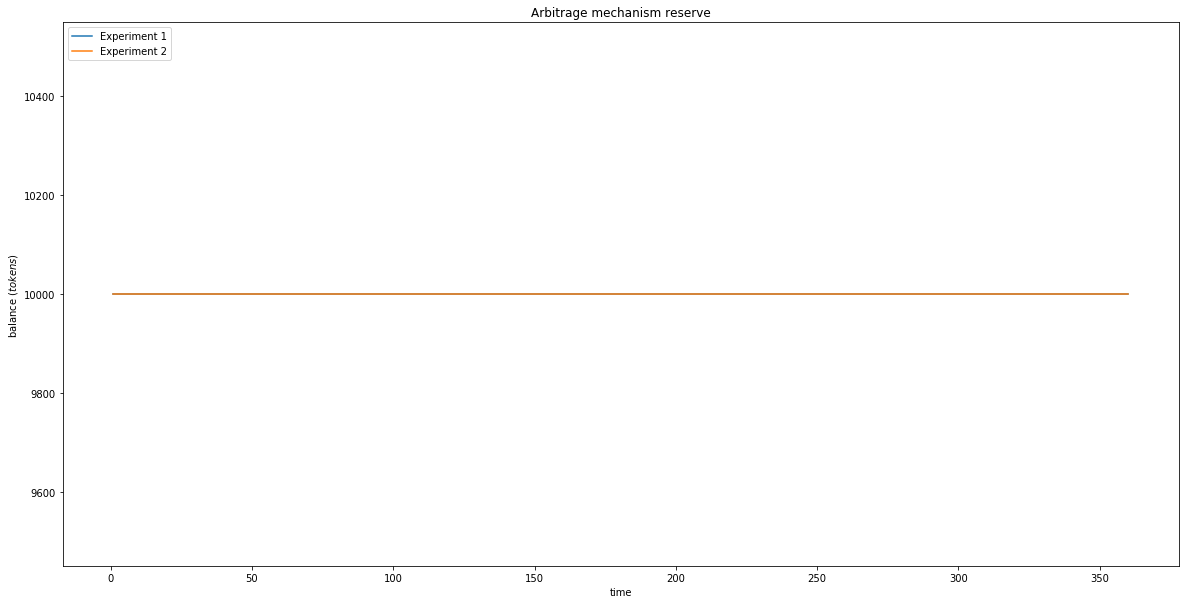

In [22]:
generic_actor_type = Nodes.ARBITRAGE.name
actor = get_node_ids_of_type(network, generic_actor_type)[0]

for experiment in params['sweep']:
    data_id = 'arbitrage_mechanism_reserve'
    
    rdf = select_experiment(results, experiment)
    rdf[data_id] = rdf['network'].apply(lambda g: balance_of(g, actor, 'DAI'))

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id], label="Experiment %s" % experiment)
    plt.title('Arbitrage mechanism reserve')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, data_id)
    print('Minimum %s' % min(rdf[data_id]))
    print('Maximum %s' % max(rdf[data_id]))
    
plt.legend(loc='upper left')

Minimum 0
Maximum 40656
Minimum 0
Maximum 40596


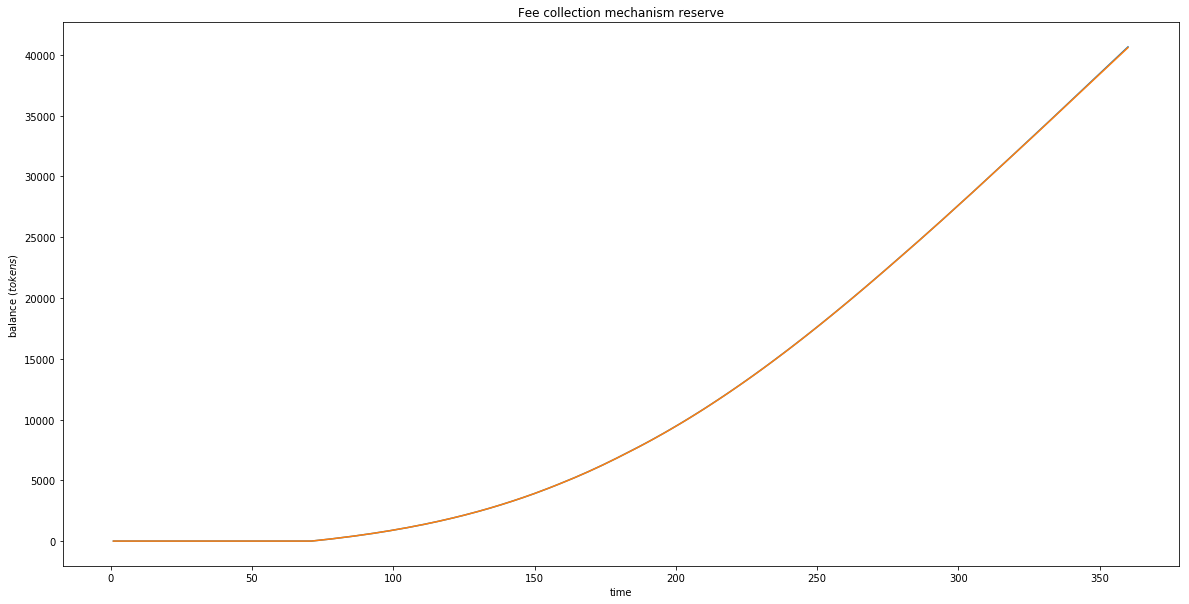

In [23]:
generic_actor_type = Nodes.FEE_POOL.name
actor = get_node_ids_of_type(network, generic_actor_type)[0]

for experiment in params['sweep']:
    data_id = 'fee_collection_mechanism_reserve'
    
    rdf = select_experiment(results, experiment)
    rdf[data_id] = rdf['network'].apply(lambda g: balance_of(g, actor, 'IXO'))

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf[data_id])
    plt.title('Fee collection mechanism reserve')
    plt.xlabel('time')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, data_id)
    print('Minimum %s' % min(rdf[data_id]))
    print('Maximum %s' % max(rdf[data_id]))